In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

# from statsmodels.stats.outliers_influence import variance_inflation_factor



%matplotlib inline

In [4]:
df = pd.read_csv('data/kc_house_data.csv')

In [5]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [6]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

# Waterfront Null Values

In [7]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [8]:
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df["waterfront"].astype(int)
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'].unique()

array([0, 1])

# Narrow to Waterfront Homes

In [9]:
df =  df.loc[df['waterfront'] == 1]

# Distributions

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 49 to 21560
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           146 non-null    int64  
 1   price        146 non-null    float64
 2   bedrooms     146 non-null    int64  
 3   bathrooms    146 non-null    float64
 4   sqft_living  146 non-null    int64  
 5   sqft_lot     146 non-null    int64  
 6   floors       146 non-null    float64
 7   waterfront   146 non-null    int64  
 8   condition    146 non-null    int64  
 9   grade        146 non-null    int64  
 10  yr_built     146 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 13.7 KB


# Scale y values to Log

In [11]:
# Create price column - log of millions
df['price_millions'] = np.log(df['price'] / 1000000)


In [12]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [13]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '${:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price,bedrooms,bathrooms,sqft_living,acres_lot,floors,waterfront,condition,grade,yr_built
count,$ 146,146.00,146.00,146.00,146.00,146.00,146.00000,146.00,146.00,146
mean,"$ 1,717,215",3.35,2.71,"3,244.75",0.59,1.63,1.00000,3.54,8.84,1962
std,"$ 1,145,385",1.10,1.12,"1,652.13",1.02,0.55,0.00000,0.74,1.78,27
min,"$ 285,000",1.00,0.75,440.00,0.05,1.00,1.00000,1.00,5.00,1905
25%,"$ 827,500",3.00,1.81,"2,082.50",0.27,1.00,1.00000,3.00,8.00,1941
50%,"$ 1,510,000",3.00,2.50,"2,900.00",0.41,2.00,1.00000,3.00,9.00,1960
75%,"$ 2,282,500",4.00,3.25,"4,117.50",0.61,2.00,1.00000,4.00,10.00,1985
max,"$ 7,060,000",6.00,6.75,"10,040.00",11.60,3.00,1.00000,5.00,12.00,2014


## Drop Unnecessary Columns

In [14]:
# Remove id because it has no predicting power, waterfront because it's all one value, and sqft_lot & year since they can't be altered.
df_model = df.drop(['acres_lot','id','price','waterfront'], axis=1)

In [15]:
df_model.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

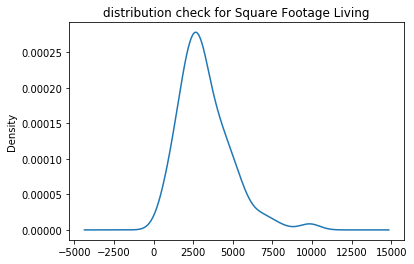

In [16]:
df_model['sqft_living'].plot.kde()
plt.title("distribution check for Square Footage Living") 
plt.show()

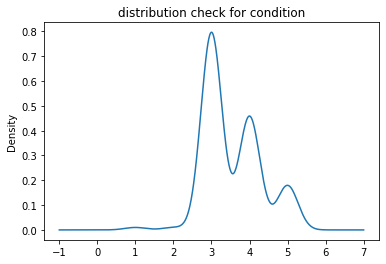

In [17]:
df_model['condition'].plot.kde()
plt.title("distribution check for condition") 
plt.show()

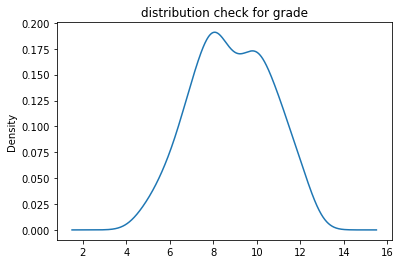

In [18]:
df_model['grade'].plot.kde()
plt.title("distribution check for grade") 
plt.show()

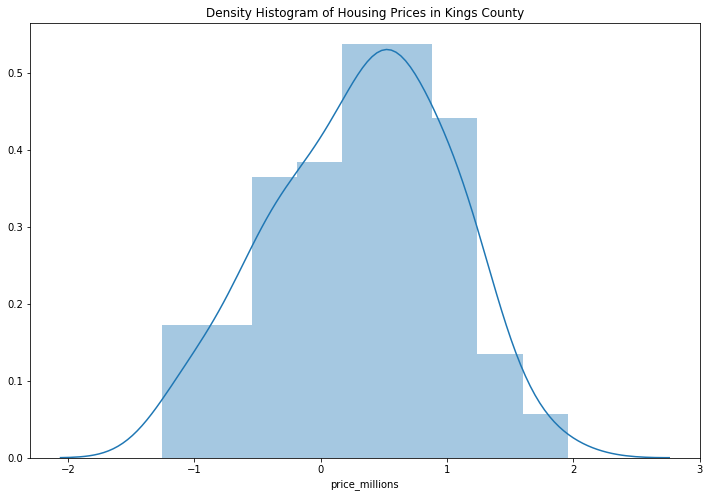

In [19]:
# From this we can see that generally, most houses are priced below one million dollars
plt.figure(figsize = (12,8))
sns.distplot(df_model.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

# Standardize Data:

In [20]:
# make copy of df_model for normalization purposes: 
df_norm = df_model.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()

for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'floors',  'condition','grade']:
    df_norm[predictor] = z_score_norm(df_norm[predictor])
# print normalized data: 
print(df_norm)

       bedrooms  bathrooms  sqft_living  sqft_lot    floors  condition  \
49    -0.317799  -0.186271    -0.297647     65005 -1.150105   1.961006   
230   -1.227578  -0.855012    -1.086324     15798  0.675062  -0.727322   
246    0.591979  -0.186271     0.245287      8354 -1.150105  -0.727322   
264   -2.137356  -1.746668    -1.503965     10079 -1.150105   1.961006   
300    0.591979   2.042869     0.790036     18641 -1.150105  -0.727322   
...         ...        ...          ...       ...       ...        ...   
19968 -0.317799  -0.186271    -0.251041      4334  2.500229  -0.727322   
20309 -0.317799   0.705385     0.705297     10756  0.675062  -0.727322   
20751  0.591979   1.151213     0.675034      8175  1.587645  -0.727322   
21185 -0.317799   0.705385     0.311867      5634  0.675062  -0.727322   
21560  1.501758   1.597041     0.971620     10584  0.675062  -0.727322   

          grade  yr_built  price_millions  
49     0.092286      1953        0.300105  
230   -1.030531      19

## Linear Regression - Ordinary Least Squares

In [21]:
# Split normalized data into target variable and predictors/explanatory variables/independent variables
X = df_norm.drop(['price_millions'], axis=1) # independent variables
y = df_norm['price_millions'] # target variable

In [22]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for teh testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)


In [23]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
lr = LinearRegression()

In [24]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)
pd.Series(coef_list, index=name_list)

bedrooms       4.495003e-02
bathrooms      1.261401e-01
sqft_living    2.543238e-01
sqft_lot      -5.782591e-07
floors         3.975722e-02
condition      3.507235e-02
grade          3.003674e-01
yr_built      -3.783871e-03
dtype: float64

In [25]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [26]:
# Model Evaluation:
# In this case, our model only explains 64% of the variation in our data 
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.7683389307932318


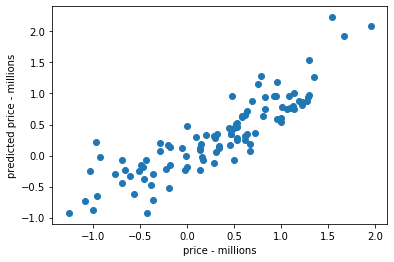

In [27]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

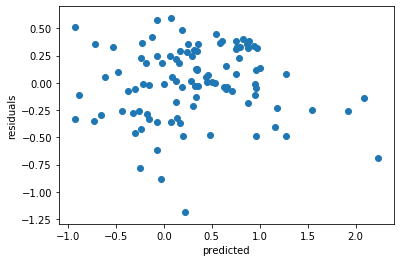

In [28]:
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation 
# Residual = Observed – Predicted
# Positive Y-values indicate the value by which the prediction was too low
# Negative Y-values indicate the value by which the prediction was too high
# Here, the model was anywhere from 5 million too low, to -2 million too high, which is quite a lot
# Additionally, the distribution of the residuals follows a clear pattern and therefore exhibits heteroscedasticity
# One of the required assumptions for linear regression is homoscedasticity (equally distributed residuals across the regression line), which we clearly do not have here


plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

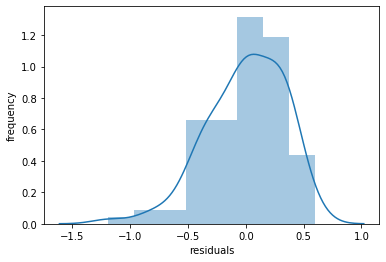

In [29]:
# See if a model of our residuals (error) follows a normal distribution:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [30]:
# Finally, we take the 30% of that data we set aside for testing, and examine the error for that:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))



The R squared value is: 0.6991061045622797
